In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, LSTM, Flatten, Activation
from keras.layers import LSTM, Input
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
from keras.layers.convolutional import Conv1D, MaxPooling1D
import keras.backend as keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import time
import bisect
import random
import functions as fns

Using TensorFlow backend.


In [2]:
def process_data(dataset):
	data = os.getcwd()+'/'+str(dataset)+'.csv'
	data = pd.read_csv(data)
	data = np.array(data)
	data = data[2:,:]
	data = data[:,1]
	data = data.astype(np.float)
	return data

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset) - look_back - 1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i+look_back])
	return np.array(dataX), np.array(dataY)

def expMa(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [3]:
look_back = 10
input_shape = (look_back, 1)
activations = ['relu']
filter_sizes = [256, 512, 1024]
kernel_sizes = [1, 2, 3]
pool_sizes = [1, 2, 3]
dense_sizes = [10, 50, 100]
dense_size = np.random.choice(dense_sizes)

visible = Input(shape=input_shape)

In [4]:
def layer_struct():
    return [np.random.choice(filter_sizes),
            np.random.choice(kernel_sizes),
            np.random.choice(range(len(activation_dict))),
            np.random.choice(pool_sizes),
            np.random.rand(),dense_size]
activation_dict = {
    str(0): 'relu',
    str(1): 'elu',
    str(2): 'sigmoid',
    str(3): 'tanh'
}

In [5]:
def build_CNN_(layers, filter_sizes, activations, dense_sizes):
    look_back = 10
    input_shape = (look_back, 1)
    #activations = ['relu']
    #filter_sizes = [256, 512, 1024]
    kernel_sizes = [1, 2, 3]
    pool_sizes = [1, 2, 3]
    #dense_sizes = [10, 50, 100]
    
    dense_size = np.random.choice(dense_sizes)
    #layers = np.random.randint(3,7)
    Architecture = np.zeros([layers,6])
    
    structure = [np.random.choice(filter_sizes),
                       np.random.choice(kernel_sizes),
                       np.random.choice(range(len(activation_dict))),
                       np.random.choice(pool_sizes),
                       np.random.rand(),dense_size]
    Architecture[0] = structure
    x = Conv1D(filters=structure[0], kernel_size=(structure[1],), padding='same')(visible)
    x = Activation(activation_dict[str(structure[2])])(x)
    x = MaxPooling1D(pool_size=(structure[3],))(x)
    x = Dropout(structure[4])(x)
    
    flag = 0
    if layers > 1:
        while flag == 0:
            try:
                for i in range(1,layers):
                    structure = [np.random.choice(filter_sizes),
                                 np.random.choice(kernel_sizes),
                                 np.random.choice(range(len(activation_dict))),
                                 np.random.choice(pool_sizes),
                                 np.random.rand(),dense_size]
                    x = Conv1D(filters=structure[0], kernel_size=(structure[1],), padding='same')(x)
                    x = Activation(activation_dict[str(structure[2])])(x)
                    x = MaxPooling1D(pool_size=(structure[3],))(x)
                    x = Dropout(structure[4])(x)
                    Architecture[i] = structure
                    flag = 1
            except Exception:
                pass
    x = Flatten()(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dense(1, activation='relu')(x)
    model = Model(inputs=visible, outputs=x)
    return model, Architecture

In [6]:
def build_CNN(i):
    activations = ['relu', 'elu', 'sigmoid', 'tanh']
    filter_sizes = [64, 128, 256, 512, 1024]
    kernel_sizes = [1, 2, 3]
    pool_sizes = [1, 2, 3]
    dense_sizes = [10, 50, 100]
    layers = np.random.randint(2,10)
    dropout = np.random.rand()
    
    try:
        length = np.random.randint(2,10)        
        model = Sequential()
        model.add(Conv1D(filters=np.random.choice(filter_sizes), kernel_size=np.random.choice(kernel_sizes), padding='same', input_shape=(look_back, 1), name='CNN_input'+str(i)))
        model.add(Activation(np.random.choice(activations)))
        model.add(MaxPooling1D(pool_size=np.random.choice(pool_sizes)))

        #for _ in range(layers):
        #    model.add(Conv1D(filters=np.random.choice(filter_sizes), kernel_size=np.random.choice(kernel_sizes), padding='same'))
        #    model.add(Activation(np.random.choice(activations)))
        #    model.add(MaxPooling1D(pool_size=np.random.choice(pool_sizes)))
        #    model.add(Dropout(dropout))
        model.add(Flatten())
        model.add(Dense(np.random.choice(dense_sizes), activation=random.choice(activations), name='CNN_dense'+str(i)))
        model.add(Dense(1, name='CNN_output'+str(i)))
    except ValueError:
        length = np.random.randint(2,10)        
        model = Sequential()
        model.add(Conv1D(filters=np.random.choice(filter_sizes), padding='same', kernel_size=np.random.choice(kernel_sizes), activation=random.choice(activations), input_shape=(look_back, 1), name='CNN_input'+str(i)))
        model.add(MaxPooling1D(pool_size=np.random.choice(pool_sizes)))
        #for _ in range(layers):
        #    model.add(Conv1D(filters=np.random.choice(filter_sizes), kernel_size=np.random.choice(kernel_sizes), padding='same'))
        #    model.add(Activation(np.random.choice(activations)))
        #    model.add(MaxPooling1D(pool_size=np.random.choice(pool_sizes)))
        #    model.add(Dropout(dropout))
        model.add(Flatten())
        model.add(Dense(np.random.choice(dense_sizes), activation=random.choice(activations), name='CNN_dense'+str(i)))
        model.add(Dense(1, name='CNN_output'+str(i)))
    return model

In [7]:
def build_LSTM(layers, layer_factor):
    look_back = 10
    Architecture = np.zeros(layers)
    
    model = Sequential()
    Architecture[0] = np.random.randint(1,10)*layer_factor
    model.add(LSTM(Architecture[0].astype(int), return_sequences=True, input_shape=(look_back, 1)))
    if layers > 1:
        for i in range(1,layers-1):
            Architecture[i] = np.random.randint(1,10)*layer_factor
            model.add(LSTM(Architecture[i].astype(int), return_sequences=True))
        Architecture[layers-1] = np.random.randint(1,10)*layer_factor
        model.add(LSTM(Architecture[layers-1].astype(int), return_sequences=False))
    Architecture = np.append(Architecture,np.random.choice(len(activation_dict)))
    model.add(Dense(1, activation=activation_dict[str(Architecture[-1].astype(int))]))
    
    return model, Architecture

In [8]:
def build_DNN(i):
    input_neurons = np.random.randint(1,10)*10
    hidden_neurons = np.random.randint(2,50)*100
    activations = ['relu', 'elu', 'sigmoid', 'tanh']
    dropout = np.random.randint(1,5)*0.1
    model = Sequential()
    model.add(Dense(input_neurons, activation=random.choice(activations), input_dim=look_back, name='DNN_input'+str(i)))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_neurons, name='DNN_last'+str(i)))
    model.add(Dense(1, name='DNN_output'+str(i)))
    return model

In [9]:
def reset_weights(model):
    session = keras.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'initializer'):
            layer.kernel.initializer.run(session=session)

In [10]:
data = pd.read_csv('healthy_person1.csv') 
data = np.array(data['raw_value'])
data = data.astype(float)
max_data = np.max(data)
for i in range(len(data)):
    data[i] = data[i] / max_data

r = 5

In [11]:
for _ in range(r):
    data = np.append(data,data)
signal_length = 155
T = len(data) / signal_length
T = 1000

In [12]:
#model = CNN_MODELS[0]
#model.summary()

In [13]:
architecture = 'LSTM'
model_num = 8
#model = load_model(os.getcwd()+'/'+architecture+'_'+str(model_num)+'.h5')
#model.summary()

In [14]:
#model, Architecture = build_CNN_(layers=5, filter_sizes=[512,1024,2048], activations=['relu'], dense_sizes=[50])
model, Architecture = build_LSTM(layers=2, layer_factor=25)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 200)           161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 225)               383400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 226       
Total params: 545,226
Trainable params: 545,226
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save(os.getcwd()+'/'+architecture+'_'+str(model_num)+'.h5')
np.save(os.getcwd()+'/Architecture_'+str(model_num)+'.npy', Architecture)

In [16]:
pop_size = 8
pop_num = 2**pop_size
N = pop_num
Pop_num = N
T = 1000
#model_num = int(model_num*10)

In [ ]:
%%time
l_r = 'test'
reset_weights(model)
num = np.floor(0.1 * pop_num)
if num < 1:
    num = 1
else:
    num = num.astype(int)
History = np.zeros(pop_num)
History[:] = np.nan
HISTORY = np.zeros([T,pop_num])
HISTORY[:] = np.nan
Weights=[{} for i in range(pop_num)]
Models=[{} for i in range(pop_num)]

alpha = 0

for t in range(T):
    print '*************************** Iteration {} **************************************'.format(t)
    y1 = data[t*signal_length : t*signal_length + 2*signal_length]
    if architecture == 'DNN':
        trainX, trainY = fns.create_dataset(y1, look_back)
    else:
        trainX_, trainY = fns.create_dataset(y1, look_back)
        trainX = np.reshape(trainX_, (trainX_.shape[0], trainX_.shape[1], 1))
    
    for i in range(pop_num):
        print i, pop_num
        learning_rate = np.random.uniform(low=0.0, high=0.001/np.float(t+1))
        keras.set_value(model.optimizer.lr, learning_rate)
        history = model.fit(trainX, trainY, validation_split=0.5, epochs=1, batch_size=1, verbose=1)
        Weights[i] = model.get_weights()
        History[i] = history.history['val_loss'][0]

    if pop_num > 1:
        pop_num = int(0.5*pop_num)
    
    idx_best = np.argsort(History)[:num]

    #if t == 0:
    #    History_old = History
    #    Weights_old = Weights
    #    idx_old = idx_best

    #if t > 0:
    #    if np.mean(History) > np.mean(History_old):
    #        History = History_old
    #        Weights = Weights_old
    #        idx_best = idx_old

    # find num best performing models
    weights = [Weights[idx] for idx in idx_best]
    new_weights = list()

    # average weight of num best performing models
    for weights_list_tuple in zip(*weights):
        new_weights.append(
            [np.array(weights_).mean(axis=0)\
                for weights_ in zip(*weights_list_tuple)])

    if len(History) < N:
        buffer1 = np.zeros(N-len(History))
        buffer1[:] = np.nan
        History = np.append(History, buffer1)
    HISTORY[t] = History
    History[:] = np.nan

    #if t > 0:
    #    if np.median(HISTORY[t]) < np.median(HISTORY[t-1]):
    #        alpha = alpha * 0.05
    #    elif alpha < 1:
    #        alpha = alpha + 0.01
    #    new_weights = np.asarray(new_weights)
    #    Weights = np.asarray(Weights)
    #    new_weights = [[x*alpha for x in y] for y in new_weights] + [[x*(1-alpha) for x in y] for y in Weights] 

    model.set_weights(new_weights)

    #print 'Alpha: ', alpha
    np.savetxt(architecture+str(model_num)+'_HISTORY_'+str(Pop_num)+str(l_r), HISTORY, delimiter=',')


*************************** Iteration 0 **************************************
0 256
Train on 149 samples, validate on 150 samples
Epoch 1/1
149/149 [==============================] - 14s 92ms/step - loss: 0.0096 - val_loss: 0.0091
1 256
Train on 149 samples, validate on 150 samples
Epoch 1/1
149/149 [==============================] - 14s 94ms/step - loss: 0.0088 - val_loss: 0.0076
2 256
Train on 149 samples, validate on 150 samples
Epoch 1/1
149/149 [==============================] - 12s 82ms/step - loss: 0.0083 - val_loss: 0.0064
3 256
Train on 149 samples, validate on 150 samples
Epoch 1/1
149/149 [==============================] - 10s 69ms/step - loss: 0.0070 - val_loss: 0.0068
4 256
Train on 149 samples, validate on 150 samples
Epoch 1/1
149/149 [==============================] - 11s 73ms/step - loss: 0.0064 - val_loss: 0.0055
5 256
Train on 149 samples, validate on 150 samples
Epoch 1/1
149/149 [==============================] - 11s 76ms/step - loss: 0.0064 - val_loss: 0.0049
6 2

In [27]:
HISTORY

array([[6.19390723e-05, 4.02023412e-05, 3.41647607e-05, ...,
        6.33716903e-05, 1.29757064e-04, 2.81492117e-05],
       [4.58472780e-05, 5.76174457e-05, 7.74728775e-05, ...,
                   nan,            nan,            nan],
       [5.96120748e-05, 2.80784048e-05, 4.39034803e-05, ...,
                   nan,            nan,            nan],
       ...,
       [3.36027910e-05,            nan,            nan, ...,
                   nan,            nan,            nan],
       [5.75801904e-05,            nan,            nan, ...,
                   nan,            nan,            nan],
       [3.90416837e-05,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [92]:
CNN_100 = np.loadtxt(architecture+str(model_num)+'_HISTORY_'+str(Pop_num)+str(j)+str(l_r), delimiter=',')

In [93]:
LSTM_40 = np.loadtxt('LSTM40_HISTORY_'+str(Pop_num)+str(j)+str(l_r), delimiter=',')

In [81]:
test_history_ = np.isnan(LSTM_40)
test_history_1 = test_history
test_history_1[test_history_] = 0

In [94]:
CNN_100_ = np.isnan(CNN_100)
CNN_100_1 = CNN_100
CNN_100_1[CNN_100_] = 0

In [96]:
test_data = np.zeros(T)
CNN_data = np.zeros(T)
for i in range(T):
    test_data[i] = test_history_1[i,:][np.nonzero(test_history_1[i,:])].mean()
    CNN_data[i] = CNN_100_1[i,:][np.nonzero(CNN_100_1[i,:])].mean()
test_data1 = fns.expMa(test_data,10)
CNN_data1 = fns.expMa(CNN_data,10)

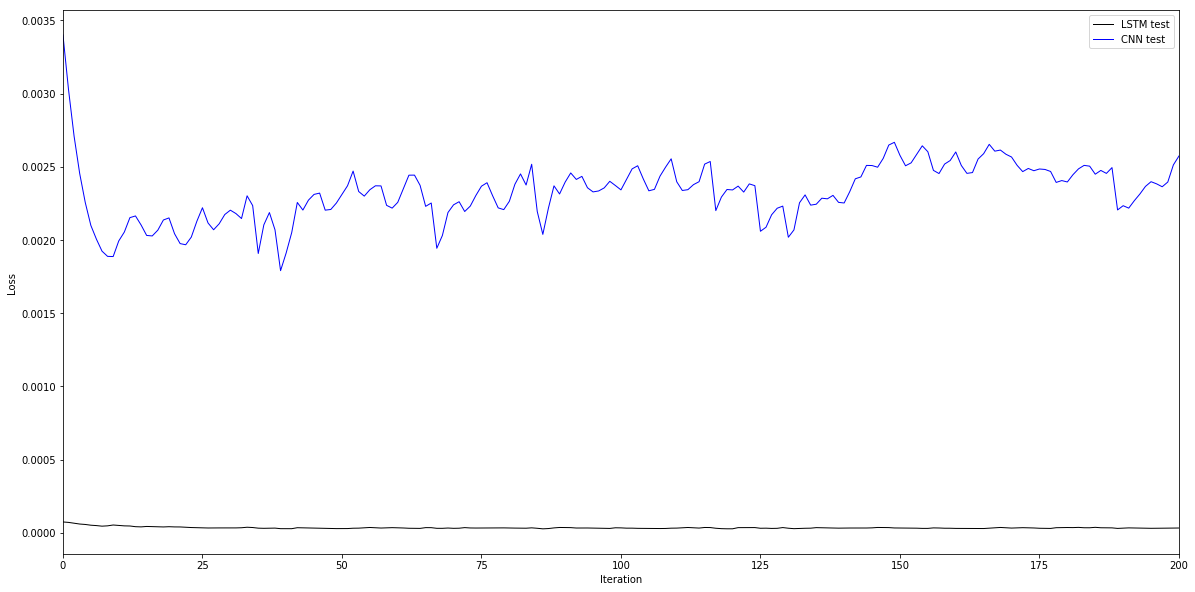

In [98]:
plt.figure(figsize=(20,10))
plt.plot(test_data1, 'k', linewidth=1, label='LSTM test')
plt.plot(CNN_data1, 'b', linewidth=1, label='CNN test')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.ylim([0,0.0001])
#plt.xlim([0,T])
plt.xlim([0,200])
plt.show()